## Part III - Portfolio Optimization 

### 3.1 - Standard Approach - Mean Variance Optimization  

In [1]:
# Import relevant libraries

import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy as sp
import numpy as np 
import math

# importer l'Excel de prix 

index_df = pd.read_excel('Data\indices.xls') 
index_df.head()

,STOXX 600,STOXX 50,S&P 500,TOPIX,FTSE,DAX,NIKKEI,NASDAQ
1990-01-01,108.16,1098.49,353.40,2881.37,2422.7,1778.119995,38915.87109,454.82
1990-01-02,108.63,1101.34,359.69,2881.37,2434.1,1788.890015,38915.87109,459.33
1990-01-03,110.04,1112.82,358.76,2881.37,2463.7,1867.290039,38915.87109,460.90
1990-01-04,110.02,1113.02,355.67,2867.70,2451.6,1830.920044,38712.87891,459.39
1990-01-05,109.02,1099.52,352.20,2834.61,2444.5,1812.900024,38274.76172,458.22


In [2]:
portfolio_return =  []
portfolio_volatility = []
stock_weights = []

# Combinaisons de portefeuilles 
number_assets = 8
num_portfolios = 1500 # On simule 50000 portfolio 

index_dictionnary = {"0" : "STOXX 600", "1":"STOXX 50","2" : "S&P 500","3" : "TOPIX", "4": "FTSE", "5":"DAX", "6":"NIKKEI","7":"NASDAQ"}
index_returns = []

In [3]:
def computeExpectedReturns(index_dictionnary):
    expected_return = []
    for key in index_dictionnary:
        Xi = index_dictionnary.get(key)
        n = len(index_df[Xi])
        expected_return.append(((index_df[Xi]-index_df[Xi].shift(1)) /index_df[Xi].shift(1)).dropna().mean() * 250) # moyenne des daily returns annualizés 
    return expected_return 
        
index_return = computeExpectedReturns(index_dictionnary)
print(index_return)

[0.0576093134836161, 0.0596820337955574, 0.08466305397055324, 0.003536995146694015, 0.05258133129504075, 0.08896481724354745, 0.008491434868693666, 0.12036859368121652]


In [4]:
def grossReturn(Xi):
    return (index_df[Xi]/index_df[Xi].shift(1)).dropna()  # dropna() allows to remove the "NaN" from the list

# Retourne la matrice de covariance

def covarianceMatrix(index_dictionnary):
    n = len(index_dictionnary) # Regarde la taille du dictionnaire
    covariance = np.zeros((n,n)) # Création d'une matrice vide de taille n*n pour stocker les valeurs de covariance

    for i in range(0,n):
        for j in range(0,n):
            Xi = index_dictionnary.get(str(i))  # Recupere le nom de la colonne Xi
            Xj = index_dictionnary.get(str(j))  # Recupere le nom de la colonne Xj
            covariance[i][j] = np.cov(grossReturn(Xi),grossReturn(Xj))[0][1] ## Calcule la covariance
    return covariance



In [5]:
## Génération de portefeuilles aléatoires

# Expected return is estimated from 1Y return for each asset 

for portfolio_i in range(num_portfolios):
    
    # on randomize le vecteur d'allocation
    allocation = np.random.random(number_assets) 
    
    # Initialisation du vecteur des prix
    price = np.zeros(number_assets)
    
    # Les poids du portefeuille sont calcule "aujourd'hui": on affecte au vecteur "price" la dernière valeur du stock
    for i in range(0,number_assets): 
        Xi = index_dictionnary.get(str(i))
        price[i] = index_df[Xi].tail(1)
    
    wa = np.dot(np.diag(allocation),price)  # On calcule le vecteur de poids avec diag(allocation) * vect(prix)
    wa /= np.sum(wa) # et on normalize le vecteur de poids
    
    # On calcule l'expected return du portefeuille de poids aléatoires 
    returns = np.dot(wa,computeExpectedReturns(index_dictionnary))
    portfolio_return.append(returns)
    
    # On calcule la volatilité du portefeuille
    volatility = np.sqrt(np.dot(wa.T,np.dot(covarianceMatrix(index_dictionnary),wa)))*np.sqrt(250)  ## Ne pas oublier d'annualiser la vol !!!
    portfolio_volatility.append(volatility)
    


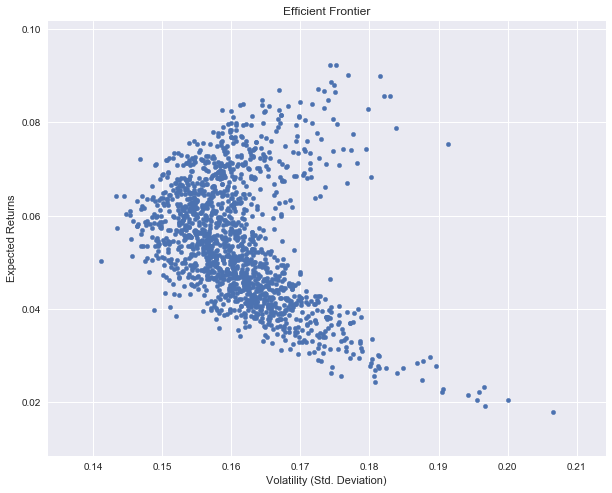

In [6]:
portfolio = {"Returns": portfolio_return, "Volatility" : portfolio_volatility} # Création d'un dictionnaire pour stocker les valeurs
result_df =pd.DataFrame(portfolio) # conversion en dataframe

#print(result_df)

plt.style.use('seaborn')
result_df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [ ]:
Optimization Algorithm